In [10]:
"""
Created on Nov 24 2024

@author: Andrea, starting from Katarina's work   

Consider a relativistic muon crossing a WCD vertically. 
The energy deposit is firstly computed from the Bethe formula, 
then considering a Landau distribution.     
 
"""

import numpy as np  

# Define relevant physical constants   
m0 = 105.6583745 # MeV, muon mass
me = 0.510998950 # MeV, electron mass 

# # Define WCD cylinder tank dimensions  
h = 120 #cm 
r = 180 #cm 

# Choose kinetic energy of the muon 
ek = 1000. # 1000 MeV = 1 GeV 

# Compute beta and gamma for the particle 

p =  np.sqrt(ek*ek + 2*ek*m0)
def _beta(ek):
    return np.sqrt(ek*ek + 2*ek*m0) / (ek+m0) 
def _gamma(ek): 
    return 1 / np.sqrt( 1 - _beta(ek)*_beta(ek) ) 

In [69]:
print('***** Starting values for the muon *****')
print('p = ',p,' MeV  c^-1') 
print('beta = ',_beta(ek))
print('gamma = ',_gamma(ek)) 
print('beta * gamma =  ', _beta(ek)*_gamma(ek),'\n')

beta = _beta(ek)
gamma = _gamma(ek)


***** Starting values for the muon ***** 

p =  1100.5983595299422  MeV  c^-1
beta =  0.9920439069958685
gamma =  7.943293707236796
beta * gamma =   7.880096123742888 



In [71]:
# For 0.1 < beta*gamma < 1000, the mean energy loss rate of a heavy charged particle in a medium is described by the Bethe equation 
# Start preparing the "ingredients" for the Bethe equation

# First, Compute maximum energy transfer to an electron of target material in a single collision 

def _Wmax(_ek):
    tmp_beta = _beta(_ek)
    tmp_gamma = _gamma(_ek)
    return 2*me*(tmp_beta*tmp_gamma)**2 / (1 + 2*tmp_gamma*me / m0 + (me / m0)**2  )

print('***** Maximum energy transfer to an electron for starting muon: ***** ')
print('Wmax = ',_Wmax(ek) / 1e3,' GeV\n' ) 

***** Maximum energy transfer to an electron for starting muon: ***** 
Wmax =  0.05893256204619674  GeV



In [55]:
# Look up material properties (water)
# https://pdg.lbl.gov/2024/AtomicNuclearProperties/HTML/water_liquid.html  

Z_A=0.55509 #mol g^-1, atomic number Z over atomic mass mol g^-1 
rho=1 #g cm^-3, density of liquid water 
I=7.97e-5 #MeV, mean excitation energy

K=0.307075 #MeV mol^−1 cm2

# Define the Bethe formula as a funcion taking beta, gamma as arguments. Dimension of dE/dx is MeV/cm 

def de_dx(_ek):
    tmp_beta = _beta(_ek)
    tmp_gamma = _gamma(_ek) 
    return K*Z_A*(1/tmp_beta**2) * (0.5 *np.log(2*me* tmp_beta**2 *tmp_gamma**2 * _Wmax(_ek) / I**2) - tmp_beta**2 ) * rho  

e_loss = de_dx(ek) * h 
print('*****  Energy loss across the tank with constant dE/dx *****')
print(e_loss, 'MeV')

261.0932995466105 MeV


In [72]:
# Try splitting the muon path inside the tank into smaller steps of dx = 10 cm
# Update energy of muon after each step  

print('*****  Computing dE/dx in steps across the tank *****\n')

def _eloss_step(_ek,_dx): 
    _eloss = de_dx(_ek) * _dx 
    print('Step energy loss: ', _eloss, 'MeV')
    return _eloss

dx = 10 #cm 

# As a first check, compute energy loss for a dx = 10 cm step in water  

ek = 1000 # GeV
eloss = _eloss_step(ek,dx)

# Update kinetic energy, beta and gamma
ek = ek - eloss  
beta = _beta(ek)
gamma = _gamma(ek)  
print('Muon energy after one step: ', ek)


*****  Computing dE/dx in steps across the tank *****

Step energy loss:  22.54684241632768 MeV
977.4531575836724


In [58]:
# Now compute energy loss with nsteps to cover the full height of the tank (h = 120 cm )

print('*****  Now iterate steps for the full height of the tank *****\n')

ek = 1000. # re-set the energy to 1 GeV  

nsteps = int(h/dx)
tot_eloss = 0.

# Initialize arrays to save energy loss and beta*gamma at each step 
eloss_array = np.zeros(nsteps)
bg_array = np.zeros(nsteps)

for i in range(nsteps): 
    eloss = _eloss_step(ek, dx)
    tot_eloss += eloss
     
    ek = ek - eloss  
    
    eloss_array[i] = eloss / (dx * rho)
    bg_array[i] = _beta(ek) * _gamma(ek)
    
print('\nMuon kinetic energy after passage in the tank: ', ek, 'MeV')    
print('Total energy deposited in the tank:', tot_eloss, 'MeV')
print('Check: ', ek + tot_eloss )


Energy loss:  22.54684241632768 MeV
Energy loss:  22.486282885916154 MeV
Energy loss:  22.424913733689166 MeV
Energy loss:  22.362724371117842 MeV
Energy loss:  22.299705198022245 MeV
Energy loss:  22.23584784769118 MeV
Energy loss:  22.17114547870078 MeV
Energy loss:  22.105593122749543 MeV
Energy loss:  22.03918809988977 MeV
Energy loss:  21.971930515104305 MeV
Energy loss:  21.903823853401715 MeV
Energy loss:  21.834875694667755 MeV
733.617126782722 MeV
266.38287321727813 MeV
Check:  1000.0000000000002
10.202179331707233


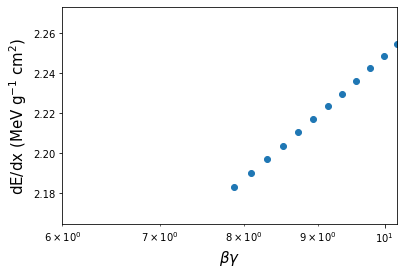

In [74]:
# Plot dE/dx as a function of beta*gamma 

import matplotlib.pyplot as plt

plt.xscale('log')
plt.xlim(6,10.2)
plt.xlabel(r'$\beta \gamma$', size = 15)
plt.ylabel(r'dE/dx (MeV g$^{-1}$ cm$^{2}$)', size =  15)
plt.scatter(bg_array, eloss_array)

In [77]:
# In this way we have computed the energy loss based on the mean rate given by the Bethe formula
# Now let's take into account the energy loss probability distribution, described by a Landau distribution   
# Install landaupy with "pip install git+https://github.com/SengerM/landaupy"

from landaupy import landau

# Define function to compute energy loss from a Landau distribution at each step 
 
def _eloss_step_landau(_ek,_dx):
    beta = _beta(_ek)
    gamma = _gamma(_ek) 
    
    # Width of the Landau 
    width =  K/2*Z_A*(_dx*rho/beta**2) 
    
    # MPV of the Landau 
    mpv = width \
            *( np.log(2*me*beta**2*gamma**2/I) \
                +np.log(width/I) + 0.2
                         -beta**2 )
    
    # Extract a value from the Landau distribution         
    _eloss = landau.sample(x_mpv=mpv, xi=width, n_samples=1) 
    
    print('Step energy loss: ', _eloss, 'MeV')
    return _eloss


Step energy loss:  1.9243190079359729 MeV


In [84]:
# Now let's simulate steps inside the tank, each time extracting the energy loss from the Landau distribution

print('*****  Iterate steps for the full height of the tank *****')
print('*****  computing energy loss from a Landau distribution *****\n')

ek = 1000. # reset primary kinetic energy 

d_eloss_array = np.zeros(nsteps)
tot_eloss_landau = 0.
 
for i in range(nsteps): 
    eloss = _eloss_step_landau(ek,dx)
    tot_eloss_landau += eloss 
    d_eloss_array[i] = eloss
    tot_eloss += eloss
     
    ek = ek - eloss  
    
print('\nMuon kinetic energy after passage in the tank: ', ek, 'MeV')    
print('Total energy deposited in the tank:', tot_eloss_landau, 'MeV')


*****  Iterate steps for the full height of the tank *****
*****  computing energy loss from a Landau distribution *****

Step energy loss:  20.222062976503143 MeV
Step energy loss:  22.68267982799023 MeV
Step energy loss:  23.455092815075844 MeV
Step energy loss:  49.21831038546553 MeV
Step energy loss:  20.533277071239986 MeV
Step energy loss:  19.605017516192433 MeV
Step energy loss:  19.571025049509114 MeV
Step energy loss:  25.524625044750923 MeV
Step energy loss:  19.12133246239245 MeV
Step energy loss:  28.478333303720483 MeV
Step energy loss:  21.024159141704807 MeV
Step energy loss:  23.524708907151798 MeV

Muon kinetic energy after passage in the tank:  707.0393754983032 MeV
Total energy deposited in the tank: 292.96062450169677 MeV


(array([0., 0., 0., 0., 0., 0., 0., 0., 1., 3., 2., 0., 1., 2., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([10.        , 11.03448276, 12.06896552, 13.10344828, 14.13793103,
        15.17241379, 16.20689655, 17.24137931, 18.27586207, 19.31034483,
        20.34482759, 21.37931034, 22.4137931 , 23.44827586, 24.48275862,
        25.51724138, 26.55172414, 27.5862069 , 28.62068966, 29.65517241,
        30.68965517, 31.72413793, 32.75862069, 33.79310345, 34.82758621,
        35.86206897, 36.89655172, 37.93103448, 38.96551724, 40.        ]),
 <a list of 1 Patch objects>)

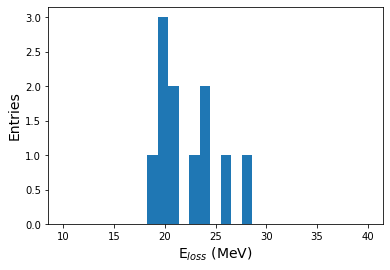

In [86]:
plt.xlabel(r'E$_{loss}$ (MeV)', size = 14)
plt.ylabel('Entries', size = 14)
plt.hist(d_eloss_array, bins = np.linspace(10,40,30), histtype='stepfilled')
